#Import Lib

In [ ]:
import os
import numpy as np
from skimage.transform import rescale, resize
import tensorflow as tf
from tqdm.keras import TqdmCallback
from skimage import data  # Importing sample data module from skimage
from matplotlib import pyplot as plt


# Check Version

In [ ]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.17.1
Num GPUs Available:  1


# Noising Image

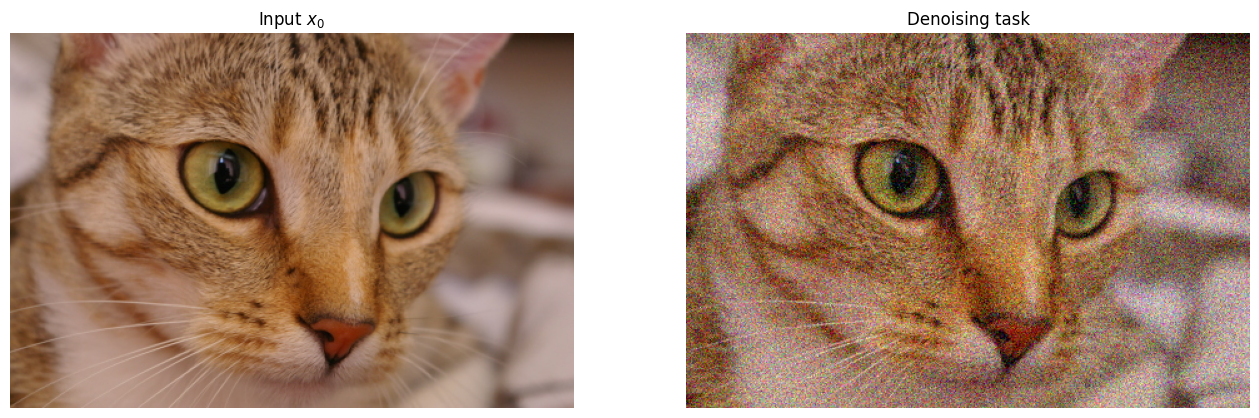

In [ ]:
def get_noisy_img(img, sig=30):
    """Task 1: Add white noise to an image.
    Args:
        img: Input image as a NumPy array.
        sig: Standard deviation of the noise to be added (default is 30).
    Returns:
        A noisy image with values clipped between 0 and 1.
    """
    sigma = sig / 255.  # Normalize the noise level to the range [0, 1]
    noise = np.random.normal(scale=sigma, size=img.shape)  # Generate Gaussian noise
    img_noisy = np.clip(img + noise, 0, 1).astype(np.float32)  # Add noise and clip values
    return img_noisy



# Load the sample image (Chelsea the cat) from skimage and normalize to [0, 1]
img = data.chelsea().astype(np.float32) / 255.

# Create a side-by-side comparison plot for the original and noisy images
_, axis = plt.subplots(1, 2, figsize=(16, 5))  # Create a figure with 2 subplots
axis[0].imshow(img)  # Display the original image in the first subplot
axis[0].set_title("Input $x_0$")  # Set the title for the original image

# Generate a noisy version of the image and display it in the second subplot
axis[1].imshow(get_noisy_img(img))
axis[1].set_title("Denoising task")  # Set the title for the noisy image

# Remove axis labels for both subplots
for ax in axis:
    ax.set_axis_off()

# Display the plot
plt.show()


## Work Flow

In [ ]:
def dip_workflow(x0,
                 x_true,
                 f,
                 f_input_shape,
                 z_std=0.1,
                 loss_mask=None,
                 num_iters=1,
                 init_lr=0.01,
                 save_filepath=None):
    """Deep Image Prior (DIP) workflow for image restoration tasks.
    Args:
        x0: Input image (e.g., noisy or corrupted image).
        x_true: Ground-truth image used for metrics evaluation.
        f: Neural network model acting as the prior for the restoration task.
        f_input_shape: Shape of the inputs to the model `f` (excluding batch size).
        z_std: Standard deviation for generating random input `z` (default 0.1).
        loss_mask: Binary mask (same shape as x0) to apply to images during loss calculation. Useful for inpainting.
        num_iters: Number of training iterations (default 1).
        init_lr: Initial learning rate for the Adam optimizer (default 0.01).
        save_filepath: Path to save the best model weights. If None, weights are not saved.

    Returns:
        Restored image after applying the DIP workflow.
    """
    # Generate a random input `z` for the neural network `f`
    shape = (1,) + f_input_shape  # Include batch dimension
    z = tf.constant(np.random.uniform(size=shape).astype(np.float32) * z_std, name='net_input')

    # Define the loss function
    def loss_fn(x_true, x):
        del x_true  # Ground-truth is not used directly in the loss calculation
        nonlocal x0, loss_mask
        if loss_mask is None:
            return tf.keras.losses.MSE(x, x0)  # Compute MSE between generated and input images
        else:
            return tf.keras.losses.MSE(x * loss_mask, x0 * loss_mask)  # Apply mask before loss calculation

    # Define metrics for evaluation
    def mse_to_gt(x_true, x):
        """Mean Squared Error between the generated image and ground-truth."""
        return tf.reduce_mean(tf.square(x - x_true))

    def psnr_to_gt(x_true, x, maxv=1.0):
        """Peak Signal-to-Noise Ratio (PSNR) between generated and ground-truth images."""
        mse = tf.reduce_mean(tf.square(x - x_true))
        psnr_ = 10.0 * tf.math.log(maxv**2 / mse) / tf.math.log(10.0)
        return psnr_

    # Compile the model with the optimizer and loss function
    opt = tf.keras.optimizers.Adam(learning_rate=init_lr)
    f.compile(optimizer=opt, loss=loss_fn, metrics=[mse_to_gt, psnr_to_gt])

    # Prepare callbacks for saving the best model
    callbacks = ()
    if save_filepath is not None:
        callbacks = create_saving_callback(save_filepath)

    # Train the model using the random input `z`
    history = f.fit(z,
                    x_true[None, ...],  # Add batch dimension to ground-truth image
                    epochs=num_iters,
                    steps_per_epoch=1,
                    verbose=0,
                    callbacks=callbacks+(TqdmCallback(verbose=1),))

    # Generate the restored image using the trained model
    x = f.predict(z)[0]

    # Visualize training dynamics and results
    fig = plt.figure(figsize=(10, 12), constrained_layout=True)
    gs = fig.add_gridspec(3, 2)
    axes = [fig.add_subplot(gs[0, :]),  # Training dynamics
            fig.add_subplot(gs[1, 0]),  # Input image
            fig.add_subplot(gs[1, 1]),  # Ground-truth image
            fig.add_subplot(gs[2, 0]),  # Last model output
            fig.add_subplot(gs[2, 1])]  # Best model output (optional)
    for ax in axes[1:]:
        ax.set_axis_off()  # Remove axes for images

    # Plot training history
    for key in history.history.keys():
        axes[0].plot(range(num_iters), history.history[key], label=key)
    axes[0].set_yscale('log')  # Log scale for better visualization
    axes[0].legend()
    axes[0].set_title("Training dynamics")

    # Display images
    axes[1].imshow(x0); axes[1].set_title('Input image')
    axes[2].imshow(x_true); axes[2].set_title('Ground-truth')
    axes[3].imshow(x); axes[3].set_title(f'Last output (PSNR = {psnr_to_gt(x_true, x):.2f})')

    # If the best model was saved, load it and display its output
    if save_filepath is not None and os.path.exists(save_filepath):
        f.load_weights(save_filepath)
        x_opt = f.predict(z)[0]
        axes[4].imshow(x_opt)
        axes[4].set_title(f'Best model output (PSNR = {psnr_to_gt(x_true, x_opt):.2f})')
    plt.show()

    # Return the restored image
    return x


# Main Model

In [ ]:
def create_saving_callback(filepath):
    """
    Creates a callback to save the best model during training.

    Args:
        filepath (str): The base file path where the model checkpoint will be saved.
                        The function appends the '.keras' extension to the file.

    Returns:
        tuple: A tuple containing a single ModelCheckpoint callback. This callback
               saves the model weights to the specified filepath whenever the monitored
               metric ('loss') improves during training.
    """
    return (
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{filepath}.keras",  # Filepath with '.keras' extension
            monitor='loss',  # Monitors the 'loss' metric during training
            verbose=0,  # No detailed logs are printed when saving
            save_best_only=True,  # Saves the model only if the current 'loss' is the lowest
            mode='min'  # Looks for the minimum value of the 'loss' metric
        ),
    )


def deep_image_prior(input_shape,
                     noise_reg=None,
                     layers=(128, 128, 128, 128, 128),
                     kernel_size_down=3,
                     kernel_size_up=3,
                     skip=(0, 4, 4, 4, 4)):
    """
    Constructs a Deep Image Prior model.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        noise_reg (dict, optional): Parameters for Gaussian noise regularization (e.g., {'stddev': 0.1}).
        layers (tuple): Number of filters for each layer in the downsampling and upsampling stages.
        kernel_size_down (int): Kernel size for downsampling convolutional layers.
        kernel_size_up (int): Kernel size for upsampling convolutional layers.
        skip (tuple): Number of skip connection filters for each depth.

    Returns:
        tf.keras.Model: Compiled Deep Image Prior model.
    """

    def norm_and_active(x):
        """
        Applies batch normalization and LeakyReLU activation to the input tensor.
        """
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        return x

    # Initialize model and input layer
    model = tf.keras.models.Sequential(name="Deep Image Prior")
    inputs = tf.keras.Input(shape=input_shape)

    ## Inputs
    x = inputs
    if noise_reg is not None:  # Add Gaussian noise regularization if specified
        x = GaussianNoiseWithDecay(**noise_reg)(x)

    ## Downsampling layers
    down_layers = []  # Store skip connections for later use
    for i, (num_filters, do_skip) in enumerate(zip(layers, skip)):
        # Add skip connections if specified
        if do_skip > 0:
            down_layers.append(
                norm_and_active(
                    tf.keras.layers.Conv2D(
                        filters=do_skip, kernel_size=1, strides=1, name=f"conv_skip_depth_{i}"
                    )(x)
                )
            )
        # Add downsampling convolutional layers
        for j, strides in enumerate([2, 1]):  # Strides=2 for downsampling, Strides=1 for refinement
            x = norm_and_active(
                tf.keras.layers.Conv2D(
                    num_filters, kernel_size_down, strides=strides, padding='same',
                    name=f"conv_down_{j + 1}_depth_{i}"
                )(x)
            )

    ## Upsampling layers
    for i, (num_filters, do_skip) in enumerate(zip(layers[::-1], skip[::-1])):
        # Upsample to the previous resolution
        x = tf.keras.layers.UpSampling2D(interpolation='bilinear', name=f"upsample_depth_{i}")(x)
        if do_skip:  # Concatenate skip connections if present
            x = tf.keras.layers.Concatenate(axis=-1)([x, down_layers.pop()])
        # Add upsampling convolutional layers
        for j, kernel_size in enumerate([kernel_size_up, 1]):
            x = norm_and_active(
                tf.keras.layers.Conv2D(
                    num_filters, kernel_size, strides=1, padding='same',
                    name=f"conv_up_{j + 1}_depth_{i}"
                )(x)
            )

    ## Output layer
    x = tf.keras.layers.Conv2D(filters=3, kernel_size=1, strides=1, name="conv_out")(x)
    x = tf.keras.layers.Activation('sigmoid')(x)  # Sigmoid activation to normalize outputs to [0, 1]
    return tf.keras.Model(inputs=inputs, outputs=x, name="deep_image_prior")

## Training and Visualization

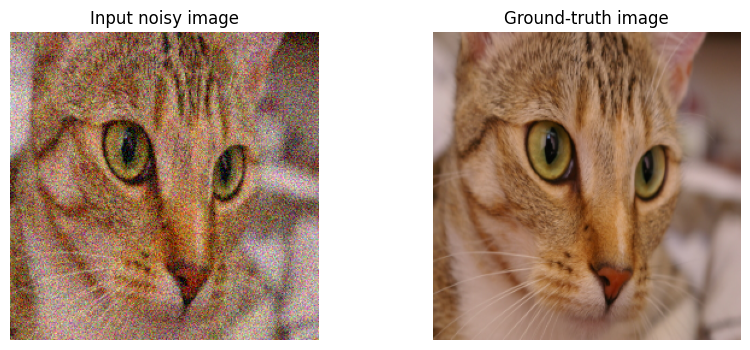

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


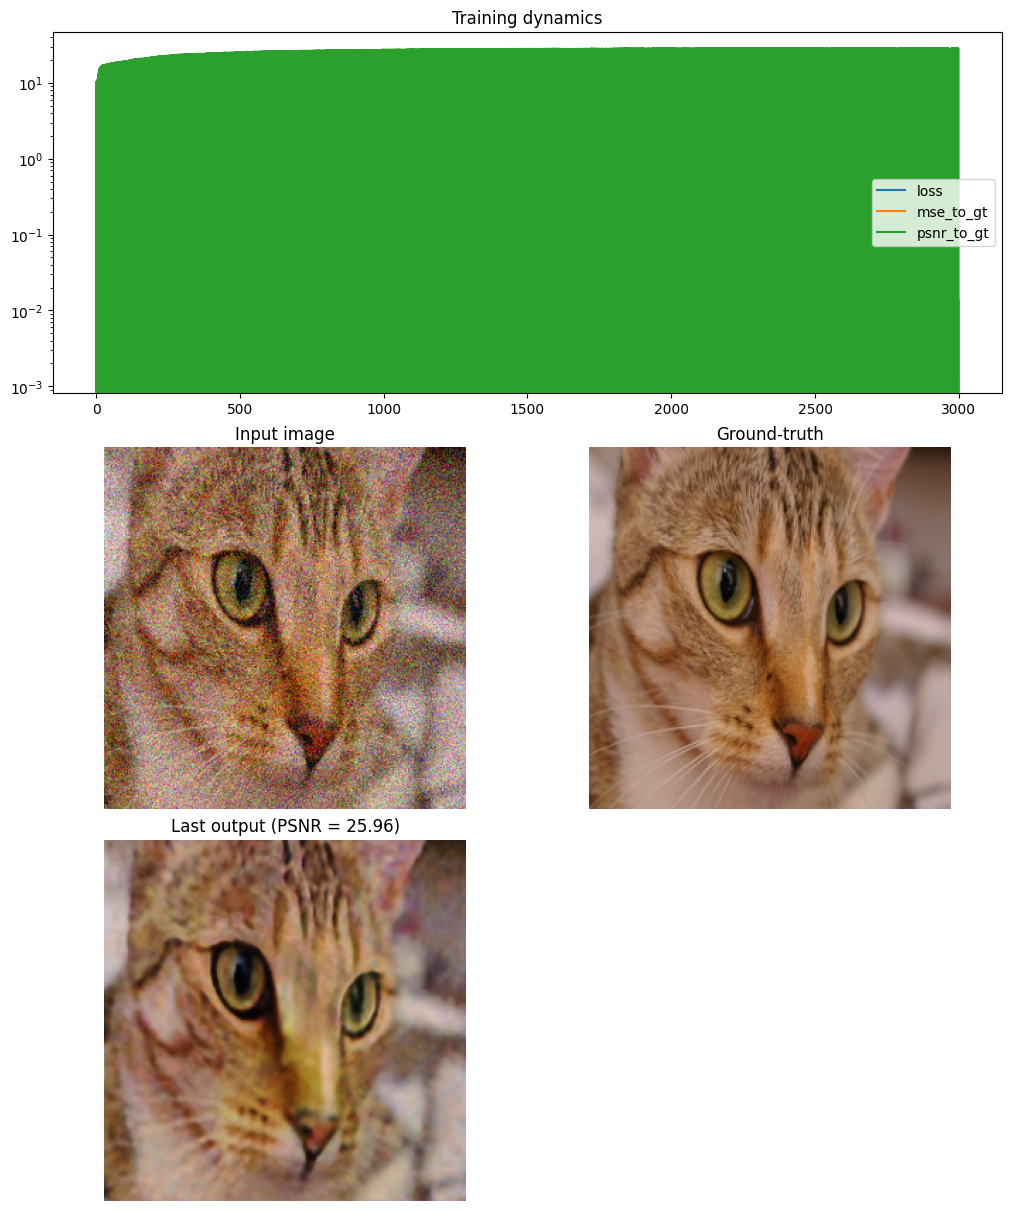

In [ ]:
class GaussianNoiseWithDecay(tf.keras.layers.GaussianNoise):
    def __init__(self, stddev, decayrate=0.99999, decaysteps=1, **kwargs):
        """
        A custom Gaussian noise layer with decaying noise standard deviation.
        Inherits from tf.keras.layers.GaussianNoise.

        Args:
            stddev (float): Initial standard deviation of the Gaussian noise.
            decayrate (float): Decay rate for the standard deviation. Multiplied
                               with the current stddev after every decaystep.
                               Default is 0.99999 (very slow decay).
            decaysteps (int): Number of calls after which the stddev is decayed.
                              Default is 1.
            kwargs: Additional keyword arguments passed to the parent class.
        """
        super(GaussianNoiseWithDecay, self).__init__(stddev, **kwargs)
        self.num_calls = 0  # Tracks the number of times the layer is called
        self.decayrate = decayrate  # Rate at which the noise decays
        self.decaysteps = decaysteps  # Steps after which decay is applied

    def call(self, inputs, training=None):
        """
        Applies Gaussian noise to the inputs with decaying standard deviation.
        Noise is only added during training.

        Args:
            inputs (Tensor): Input tensor to the layer.
            training (bool): If True, noise is added. Otherwise, inputs are returned unchanged.

        Returns:
            Tensor: Input tensor with added Gaussian noise during training, or unchanged inputs during inference.
        """
        if training:
            # Increment the number of calls only during training
            self.num_calls += 1

            # Calculate the decayed standard deviation
            stddev = self.stddev * self.decayrate ** (self.num_calls // self.decaysteps)

            # Generate Gaussian noise with the decayed standard deviation
            noise = tf.random.normal(
                shape=tf.shape(inputs),  # Match the input shape
                mean=0.0,  # Noise mean is zero
                stddev=stddev,  # Use decayed standard deviation
                dtype=inputs.dtype  # Ensure noise has the same data type as inputs
            )

            # Add noise to the inputs
            return inputs + noise
        else:
            # During inference, return inputs unchanged
            return inputs



def display_dip_model(input_shape=(256, 256, 3)):
    """
    Display the architecture summary of the Deep Image Prior model.

    Args:
        input_shape (tuple): The shape of the input image (default: (256, 256, 3)).
    """
    # Create and build the model with the specified input shape
    model = deep_image_prior(input_shape)
    model.build(input_shape)

    # Print the model summary
    print(model.summary())




x_true = resize(data.chelsea().astype(np.float32) / 255., (256, 256))
x0 = get_noisy_img(x_true)
_, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(x0); axes[0].set_axis_off()
axes[0].set_title("Input noisy image")
axes[1].imshow(x_true); axes[1].set_axis_off()
axes[1].set_title("Ground-truth image")
plt.show()

input_shape = x0.shape
noise_reg = {'stddev': 1./ 30., 'decayrate': 1.0, 'decaysteps': 100}

model = deep_image_prior(input_shape, noise_reg=noise_reg)
x = dip_workflow(x0, x_true, model, input_shape, num_iters=3000, save_filepath='best_dip_denoising.hdf5')

#Exercise


**Theory:**

1. What are the main ideas in deep learning for image processing?  
2. Create a table comparing the advantages and disadvantages of deep learning compared to traditional methods for image processing (as learned last week).  
3. Why are Convolutional Neural Networks (CNNs) commonly used in image processing?  
4. What is the difference between Convolutional Neural Networks (CNNs) and Fully Connected Neural Networks in image processing?  
5. What is a Kernel (or Filter) in CNNs? How does it work?  
6. Why are pooling operations (e.g., MaxPooling, AveragePooling) important in image processing models?  
7. Explain the roles of Conv2D, BatchNormalization, and Activation layers in image processing networks.  
8. What problem do skip connections in architectures like U-Net or ResNet help solve? Why are they important?  
9. Compare popular CNN architectures like AlexNet, VGG, and ResNet in image processing.  



**Practice:**  

1. Pick a random image from the internet and perturb it with impulse noise.  
2. Refine the code to process the noisy image using a pre-designed model.  
3. Design a simple model and use it to process the noisy image.  
4. Compare the model you designed with the existing model.  

